# UNSUPERVISED LEARNING

# Mean Shift clustering

We will need:
- sklearn
- pandas
- numpy
- seaborn

Imagine that the international cruise agency Carnival Cruise Line has decided to advertise themselves via banners and asked us about this. To test whether the benefits of such banners are great, they will be placed only 20 pieces around the world. We need to choose 20 such locations for placement, so that the benefits are great and the agency continues to cooperate with us.

The agency is large and has several offices around the world. They want to place banners near these offices - it’s easier to negotiate and check the result. Also, these places should be popular among tourists.

To find the best places, we will use the database of the largest social network based on locations - Foursquare.

### Data Load

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
data = pd.read_csv('checkins.dat', sep='|', skipinitialspace=True, low_memory=False)    # Skip spaces after delimiter

In [3]:
data.head()

,id,user_id,venue_id,latitude,longitude,created_at
0,984301,2041916.0,5222.0,NaN,NaN,2012-04-21 17:39:01
1,984222,15824.0,5222.0,38.895112,-77.036366,2012-04-21 17:43:47
2,984315,1764391.0,5222.0,NaN,NaN,2012-04-21 17:37:18
3,984234,44652.0,5222.0,33.800745,-84.410520,2012-04-21 17:43:43
4,984249,2146840.0,5222.0,NaN,NaN,2012-04-21 17:42:58


For easier work with this data, we remove the rows that do not contain the coordinates - they are not informative for us.

In [4]:
# Before cleaning NaN values
data.shape

(1021967, 6)

In [5]:
# After cleaning NaN values
data.dropna(inplace = True)
data.shape

(396634, 6)

In [6]:
data.columns

Index(['id    ', 'user_id ', 'venue_id ', 'latitude      ', 'longitude     ',
       'created_at    '],
      dtype='object')

In [7]:
col = [n.strip() for n in list(data.columns)]
data.columns = col
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 396634 entries, 1 to 1021964
Data columns (total 6 columns):
id            396634 non-null object
user_id       396634 non-null float64
venue_id      396634 non-null float64
latitude      396634 non-null float64
longitude     396634 non-null float64
created_at    396634 non-null object
dtypes: float64(4), object(2)
memory usage: 21.2+ MB


In [8]:
data.columns

Index(['id', 'user_id', 'venue_id', 'latitude', 'longitude', 'created_at'], dtype='object')

## 1. Mean Shift algorithm

Now we need to cluster the data coordinates to identify centers of tourist crowds. Since banners have a relatively small area of action, we need an algorithm that allows us to manage the cluster size with no dependency on the number of clusters.

This problem - a good reason to get familiarized with the algorithm Mean Shift. Mean Shift clustering aims to discover blobs in a smooth density of samples. It is a centroid based algorithm, which works by updating candidates for centroids to be the mean of the points within a given region.

In [9]:
# Informative features
coordinats = data.loc[:,['latitude', 'longitude']]

We can use pairplot for visualization of data to get some idea about which destribution it has.

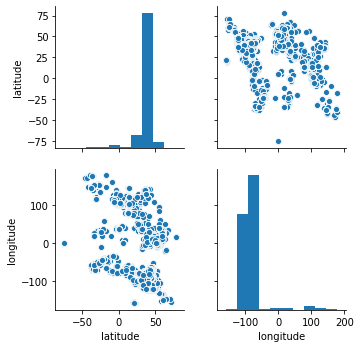

In [10]:
sns.pairplot(coordinats)

In [11]:
from sklearn.cluster import MeanShift

In [12]:
clusters = MeanShift(bandwidth=0.1, bin_seeding=True, cluster_all=False)
# bandwidth = 0.1, in terms of degrees to meters ranges from about 5 to 10 km in mil-latitudes

In [13]:
import timeit
start = timeit.default_timer()

clusters.fit(coordinats)
    
print('Time: ', timeit.default_timer() - start)

Time:  27.081824585999996


In [14]:
# Cluster's centers
centros = clusters.cluster_centers_ 
centros.shape

(5243, 2)

In [15]:
# Labels of clusters
labels = clusters.labels_
clusters.predict([[40.7177164 ,  -73.99183542]])   # example

array([0])

In [16]:
N = (np.unique(labels)).shape[0] - 1         # cluster "-1" = cluster of outliers
# N = centros.shape[0]
print('N clusters:  ', N)

N clusters:   5243


Some of the resulting clusters contain too few points - such clusters are not interesting to advertisers. Therefore, it is necessary to determine which clusters contain, for example, more than 15 elements. The centers of these clusters are optimal for placement.

In [17]:
# min_bin_freq=15
clusters = MeanShift(bandwidth=0.1, bin_seeding=True, min_bin_freq=15, cluster_all=False)

In [18]:
start = timeit.default_timer()
clusters.fit(coordinats)   
print('Time: ', timeit.default_timer() - start)

Time:  13.896361622


In [19]:
centros = clusters.cluster_centers_ 
labels = clusters.labels_
N = (np.unique(labels)).shape[0] - 1 
print('N clusters:  ', N)

N clusters:   1170


In [20]:
# New data contains coordinats of each location and label of its cluster

data_C = coordinats
data_C['Labels'] = labels

In [21]:
data_C.head()

,latitude,longitude,Labels
1,38.895112,-77.036366,4
3,33.800745,-84.410520,7
7,45.523452,-122.676207,29
9,40.764462,-111.904565,85
10,33.448377,-112.074037,3


In [22]:
# Number of outliers in data
np.sum(labels==-1)

30084

If we wish to see the result on the map, we can pass the resulting cluster centers in one of the visualization tools. For example, https://www.mapcustomizer.com/  has a Bulk Entry function where we can insert the centers of the resulting clusters in the format:

38.8951118,-77.0363658

33.800745,-84.41052

45.5234515,-122.6762071

## 2. Banner placement choice

As we remember, 20 banners should be placed near the offices of the company. We’ll find the addresses of all offices on Google Maps for Carnival Cruise Line:

In [23]:
# 33.751277, -118.188740 (Los Angeles)
# 25.867736, -80.324116 (Miami)
# 51.503016, -0.075479 (London)
# 52.378894, 4.885084 (Amsterdam)
# 39.366487, 117.036146 (Beijing)
# -33.868457, 151.205134 (Sydney)

offices = np.array ([[33.751277, -118.188740],[25.867736, -80.324116], [51.503016, -0.075479], [52.378894, 4.885084], \
                   [39.366487, 117.036146], [ -33.868457, 151.205134]])
clusters.predict(offices)

array([ 48, 187,  52, 312, 407, 236])

It remains to determine the 20 closest cluster centers, i.e. calculate the distance to the nearest office for each point and choose 20 with the lowest value.

In [24]:
from scipy.spatial.distance import euclidean as E_dist

In [25]:
distances = np.zeros((centros.shape[0], offices.shape[0]))    # 1170 x 6
for j in range(offices.shape[0]):
    for i in range(centros.shape[0]):
        distances[i,j] = E_dist(offices[j], centros[i])

In [26]:
min_dist = distances.min(axis = 1)

In [27]:
# Creating a pandas data frame with coordinats of location with distances to nearest office

centr_dist = pd.DataFrame({'Latitude': centros[:, 0], 'Longitude': centros[:, 1], 'Distance': min_dist})

In [28]:
centr_dist.head()

,Latitude,Longitude,Distance
0,40.717485,-73.989359,16.144478
1,41.878165,-87.629827,17.598501
2,33.446828,-111.902533,6.293575
3,33.448450,-112.074069,6.122165
4,38.886107,-77.048199,13.424217


In [30]:
# Sorting by nearest office and getting the 20 nearest

dist_sorted = centr_dist.sort_values(['Distance'])
dist_sorted.iloc[:20, :]

,Latitude,Longitude,Distance
236,-33.866146,151.207082,0.003023
312,52.372489,4.892268,0.009625
187,25.896896,-80.297712,0.039339
52,51.503055,-0.127113,0.051634
48,33.811275,-118.144334,0.074644
23,25.787086,-80.215128,0.135583
103,33.876328,-118.067410,0.174238
90,26.005052,-80.205598,0.181390
38,33.872013,-118.370345,0.218077
680,26.119457,-80.392560,0.260860


In [31]:
# 20 nearest places and their coordinats

dist20 = dist_sorted.iloc[:20, :] 
coordinats20 = dist20.loc[:,['Latitude', 'Longitude']]

In [32]:
clusters.predict(coordinats20)

array([236, 312, 187,  52,  48,  23, 103,  90,  38, 680,  34,  31,  59,
       894,  11, 151, 931,  89,  18,  47])